# 협업필터링(Memory 기반)
 > 출처 : https://alex-blog.tistory.com/entry/Collaborative-Filtering

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from sklearn.metrics.pairwise import cosine_similarity
import operator
%matplotlib inline

In [7]:
movie=pd.read_csv('./archive/movies.csv')
rating=pd.read_csv('./archive/ratings.csv')
tags=pd.read_csv('./archive/tags.csv')

In [8]:
movie.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [10]:
rating.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [18]:
df=pd.merge(rating,movie,how='left',on='movieId')

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100004 entries, 0 to 100003
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100004 non-null  int64  
 1   movieId    100004 non-null  int64  
 2   rating     100004 non-null  float64
 3   timestamp  100004 non-null  int64  
 4   title      100004 non-null  object 
 5   genres     100004 non-null  object 
dtypes: float64(1), int64(3), object(2)
memory usage: 5.3+ MB


{'whiskers': [<matplotlib.lines.Line2D at 0x198f26c4bc8>,
 'caps': [<matplotlib.lines.Line2D at 0x198f26de848>,
 'boxes': [<matplotlib.lines.Line2D at 0x198f26da8c8>],
 'medians': [<matplotlib.lines.Line2D at 0x198f26dee08>],
 'fliers': [<matplotlib.lines.Line2D at 0x198f26dee88>],
 'means': []}

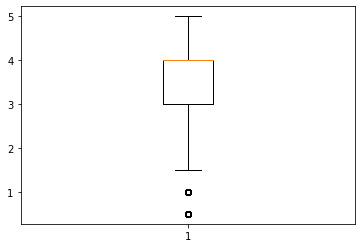

In [22]:
plt.boxplot(df['rating'])

In [26]:
df.head()

,userId,movieId,rating,timestamp,title,genres
0,1,31,2.5,1260759144,Dangerous Minds (1995),Drama
1,1,1029,3.0,1260759179,Dumbo (1941),Animation|Children|Drama|Musical
2,1,1061,3.0,1260759182,Sleepers (1996),Thriller
3,1,1129,2.0,1260759185,Escape from New York (1981),Action|Adventure|Sci-Fi|Thriller
4,1,1172,4.0,1260759205,Cinema Paradiso (Nuovo cinema Paradiso) (1989),Drama


### 유사도 계산을 위한 pivoting 진행

In [27]:
piv = df.pivot_table(index=['userId'], columns=['title'], values='rating')

In [28]:
piv.head()

title,"""Great Performances"" Cats (1998)",$9.99 (2008),'Hellboy': The Seeds of Creation (2004),'Neath the Arizona Skies (1934),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),...,Zulu (1964),Zulu (2013),[REC] (2007),eXistenZ (1999),loudQUIETloud: A Film About the Pixies (2006),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931),İtirazım Var (2014)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 개개인의 평가 척도 조정을 위한 표준화 작업

In [29]:
piv_norm = piv.apply(lambda x: (x-np.mean(x))/(np.max(x)-np.min(x)), axis=1)

In [30]:
piv_norm.fillna(0, inplace=True)
piv_norm = piv_norm.T
piv_norm = piv_norm.loc[:, (piv_norm != 0).any(axis=0)]

In [31]:
piv_norm.head()

userId,1,2,3,4,5,6,7,8,9,10,...,662,663,664,665,666,667,668,669,670,671
title,,,,,,,,,,,,,,,,,,,,,
"""Great Performances"" Cats (1998)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
$9.99 (2008),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
'Hellboy': The Seeds of Creation (2004),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
'Neath the Arizona Skies (1934),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
'Round Midnight (1986),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
piv_sparse = sp.sparse.csr_matrix(piv_norm.values)
item_similarity = cosine_similarity(piv_sparse)
user_similarity = cosine_similarity(piv_sparse.T)
item_sim_df = pd.DataFrame(item_similarity, index = piv_norm.index, columns = piv_norm.index)
user_sim_df = pd.DataFrame(user_similarity, index = piv_norm.columns, columns = piv_norm.columns)

In [33]:
item_sim_df.head()

title,"""Great Performances"" Cats (1998)",$9.99 (2008),'Hellboy': The Seeds of Creation (2004),'Neath the Arizona Skies (1934),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),...,Zulu (1964),Zulu (2013),[REC] (2007),eXistenZ (1999),loudQUIETloud: A Film About the Pixies (2006),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931),İtirazım Var (2014)
title,,,,,,,,,,,,,,,,,,,,,
"""Great Performances"" Cats (1998)",1.000000,0.0,0.0,0.969031,0.871739,0.0,0.809565,0.000000,0.0,0.217758,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0
$9.99 (2008),0.000000,1.0,0.0,0.000000,0.000000,0.0,0.000000,-0.004048,0.0,0.012195,...,0.0,0.0,0.0,0.000000,0.0,0.204325,0.0,-0.003244,0.0,0.0
'Hellboy': The Seeds of Creation (2004),0.000000,0.0,1.0,0.000000,0.000000,1.0,0.000000,0.256241,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0
'Neath the Arizona Skies (1934),0.969031,0.0,0.0,1.000000,0.899598,0.0,0.835437,0.000000,0.0,0.224717,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0
'Round Midnight (1986),0.871739,0.0,0.0,0.899598,1.000000,0.0,0.751558,-0.134873,0.0,0.212178,...,0.0,0.0,0.0,-0.088278,0.0,0.000000,0.0,0.000000,0.0,0.0


In [34]:
user_sim_df.head()

userId,1,2,3,4,5,6,7,8,9,10,...,662,663,664,665,666,667,668,669,670,671
userId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.000000,0.000000,0.003620,-0.002274,0.000000,-0.070321,0.000000,0.042632,0.000000,...,0.000000,0.000000,0.018732,0.001031,0.000000,0.000000,0.000000,0.044095,0.000000,-0.013096
2,0.000000,1.000000,-0.001852,-0.004854,0.012639,0.000000,0.042691,0.021066,0.011109,-0.007989,...,-0.018248,-0.021546,0.018974,-0.058952,0.028515,-0.106828,-0.007999,-0.041628,-0.090233,0.056258
3,0.000000,-0.001852,1.000000,0.018594,-0.025903,-0.063200,0.054900,0.026488,-0.036187,0.038021,...,0.044297,0.019581,0.070855,0.030669,0.143705,0.096713,0.027451,0.089297,-0.009815,0.062276
4,0.003620,-0.004854,0.018594,1.000000,0.010801,0.019224,0.057519,0.055430,-0.010442,0.005126,...,0.011978,0.006569,0.027602,0.092092,0.021334,0.040833,0.018428,0.028642,0.019848,0.032749
5,-0.002274,0.012639,-0.025903,0.010801,1.000000,-0.005843,-0.015075,-0.038886,0.013708,0.030500,...,0.046134,0.001903,0.001663,0.036819,-0.038269,-0.019537,-0.071721,0.003760,-0.029455,-0.036814


In [35]:
def top_movie(movie):
    count = 1
    print('Similar shows to {} include:\n'.format(movie))
    result = item_sim_df.loc[~item_sim_df.index.isin([movie]), movie].sort_values(ascending = False)[:10]
    for item, score in result.items():
        print('No. {}: {}({:.2f})'.format(count, item , score))
        count +=1  

In [36]:
def top_users(user):
    if user not in piv_norm.columns:
        return('No data available on user {}'.format(user))

    print('Most Similar Users:\n')
    result = user_sim_df.sort_values(by=user, ascending=False).loc[:,user][1:11]
    for user, sim in result.items():
        print('User #{0}, Similarity value: {1:.2f}'.format(user, sim)) 

In [39]:
top_movie('"Great Performances" Cats (1998)')

Similar shows to "Great Performances" Cats (1998) include:

No. 1: Amelia (2009)(0.97)
No. 2: 'Neath the Arizona Skies (1934)(0.97)
No. 3: 100 Rifles (1969)(0.97)
No. 4: 'Round Midnight (1986)(0.87)
No. 5: 'Til There Was You (1997)(0.81)
No. 6: Astro Boy (2009)(0.63)
No. 7: Carlito's Way (1993)(0.29)
No. 8: Negotiator, The (1998)(0.29)
No. 9: 10,000 BC (2008)(0.27)
No. 10: Alice in Wonderland (1933)(0.25)


In [40]:
top_users(3)

Most Similar Users:

User #191, Similarity value: 0.29
User #445, Similarity value: 0.24
User #508, Similarity value: 0.23
User #633, Similarity value: 0.16
User #24, Similarity value: 0.16
User #304, Similarity value: 0.16
User #64, Similarity value: 0.16
User #639, Similarity value: 0.16
User #634, Similarity value: 0.15
User #267, Similarity value: 0.15


In [42]:
def similar_user_recs(user):
    if user not in piv_norm.columns:
        return('No data available on user {}'.format(user))

    # 유사도가 높은 10명의 사용자를 가져옵니다. 
    sim_users = user_sim_df.sort_values(by=user, ascending=False).index[1:11] 
    best = []
    most_common = {}


    for i in sim_users:
        # 유사도가 높은 10명의 사용자들이 평가점수를 높게 주었던 item list를 가져옵니다. 
        # 단, 주의해야할 점은 추천하려고 하는 대상 user가 평가하지 않았던 아이템이어야 합니다. 
        result_sorted = piv_norm.loc[:, i][(piv_norm.loc[:,user] == 0)].sort_values(ascending = False)
        best.append(result_sorted.index[:5].tolist())
#     print(best)
    for i in range(len(best)):
        for j in best[i]:
            if j in most_common:
                most_common[j] += 1
            else:
                most_common[j] = 1
    sorted_list = sorted(most_common.items(), key=operator.itemgetter(1), reverse=True)
    return sorted_list[:5]    

In [43]:
similar_user_recs(3)

[('Fugitive, The (1993)', 4),
 ('Quiz Show (1994)', 2),
 ('Apollo 13 (1995)', 2),
 ('Get Shorty (1995)', 2),
 ('Dances with Wolves (1990)', 2)]